In [1]:
# To get reproducible results
from numpy.random import seed
seed(1234)
from tensorflow import random
random.set_seed(1234)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    GlobalAveragePooling1D,
    Input,
    ReLU,
)
from tensorflow.keras.models import Model, load_model


# Read data generated by `get_data.ipynb`.

In [2]:
whole = pd.read_csv("all_data.csv")
whole_normal = whole[
    (whole["vv"] > -32000) & (whole["vh"] > -32000)  # -32768 means nodata
]
whole_normal = (
    whole_normal.copy()
)  # avoid `SettingWithCopyWarning`, see https://stackoverflow.com/a/75277434/
whole_normal["time"] = pd.to_datetime(whole_normal["time"])

no_label_data = pd.read_csv("no_label_data.csv")
no_label_data["time"] = pd.to_datetime(no_label_data["time"])


In [3]:
whole_normal.head()


,lat_and_long,type,time,vh,vv
0,"(10.323727047081501, 105.2516346045924)",Rice,2021-01-02,0.007281,0.064617
1,"(10.323727047081501, 105.2516346045924)",Rice,2021-01-03,0.012100,0.100834
2,"(10.323727047081501, 105.2516346045924)",Rice,2021-01-08,0.008796,0.302948
3,"(10.323727047081501, 105.2516346045924)",Rice,2021-01-14,0.013753,0.219833
4,"(10.323727047081501, 105.2516346045924)",Rice,2021-01-15,0.013327,0.317204


In [4]:
no_label_data.head()


,lat_and_long,type,time,vh,vv
0,"(10.18019073690894, 105.32022315786804)",NaN,2021-01-02,0.019622,0.201935
1,"(10.18019073690894, 105.32022315786804)",NaN,2021-01-03,0.009204,0.132878
2,"(10.18019073690894, 105.32022315786804)",NaN,2021-01-08,0.029937,0.110144
3,"(10.18019073690894, 105.32022315786804)",NaN,2021-01-14,0.033573,0.044857
4,"(10.18019073690894, 105.32022315786804)",NaN,2021-01-15,0.015343,0.096504


# Prepare data for training

In [5]:
# labeled data is used for model training
pivoted_vh_labeled = whole_normal.pivot(
    index=["lat_and_long", "type"], columns="time", values="vh"
)
pivoted_vv_labeled = whole_normal.pivot(
    index=["lat_and_long", "type"], columns="time", values="vv"
)

# non-labeled data is waiting for prediction by the trained model
pivoted_vh_non_labeled = no_label_data.pivot(
    index=["lat_and_long", "type"], columns="time", values="vh"
)
pivoted_vv_non_labeled = no_label_data.pivot(
    index=["lat_and_long", "type"], columns="time", values="vv"
)


In [6]:
pivoted_vh_labeled


,time,2021-01-02,2021-01-03,2021-01-08,2021-01-14,2021-01-15,2021-01-20,2021-01-26,2021-01-27,2021-02-01,2021-02-07,...,2022-11-05,2022-11-06,2022-11-17,2022-11-18,2022-11-29,2022-11-30,2022-12-11,2022-12-12,2022-12-23,2022-12-24
lat_and_long,type,,,,,,,,,,,,,,,,,,,,,
"(10.001224578022901, 105.50464006270187)",Rice,0.025215,0.028832,0.012674,0.011105,0.017081,0.012386,0.013689,0.011439,0.046678,0.027375,...,0.004233,0.002714,0.006625,0.003293,0.004789,0.005616,0.020921,0.007568,0.039393,0.028340
"(10.007583781638141, 105.67270472966868)",Non Rice,0.059862,0.055614,0.038370,0.072840,0.045779,0.043570,0.037782,0.046607,0.026366,0.082199,...,0.073373,0.021254,0.057311,0.096239,0.068246,0.065236,0.080313,0.072658,0.043450,0.057440
"(10.007583781638141, 105.6731589584983)",Non Rice,0.044823,0.054479,0.027847,0.030460,0.064620,0.090186,0.078088,0.054037,0.031647,0.069224,...,0.042289,0.066180,0.034884,0.117312,0.056572,0.063060,0.051258,0.072026,0.085129,0.068598
"(10.008038010467802, 105.67225050083903)",Non Rice,0.043172,0.060241,0.057650,0.048034,0.061733,0.077416,0.048733,0.063313,0.063840,0.042050,...,0.104947,0.035531,0.061555,0.058651,0.053884,0.050012,0.053884,0.050554,0.060940,0.094486
"(10.008038010467802, 105.67270472966868)",Non Rice,0.046634,0.063322,0.064363,0.076314,0.075950,0.049823,0.054621,0.050820,0.072053,0.048684,...,0.124442,0.089500,0.084661,0.069512,0.051449,0.052936,0.054008,0.047159,0.066062,0.083693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(9.995319603237322, 105.50146046089439)",Rice,0.023311,0.025825,0.020729,0.008503,0.017163,0.017014,0.025662,0.026278,0.014080,0.037824,...,0.004912,0.004463,0.002933,0.004963,0.020661,0.013650,0.022877,0.013095,0.021968,0.024157
"(9.99577383206698, 105.50554852036115)",Rice,0.023049,0.020412,0.048933,0.015760,0.021874,0.016941,0.018817,0.027317,0.024032,0.054643,...,0.004623,0.002697,0.005626,0.003534,0.004971,0.006791,0.016803,0.011984,0.027679,0.015716
"(9.996228060896641, 105.51463309695396)",Rice,0.042488,0.032269,0.029750,0.020263,0.019486,0.013542,0.020149,0.022897,0.026272,0.043450,...,0.021049,0.011478,0.020284,0.010824,0.025997,0.009762,0.042502,0.017784,0.068947,0.015353


In [7]:
pivoted_vh_non_labeled


,time,2021-01-02,2021-01-03,2021-01-08,2021-01-14,2021-01-15,2021-01-20,2021-01-26,2021-01-27,2021-02-01,2021-02-07,...,2022-11-05,2022-11-06,2022-11-17,2022-11-18,2022-11-29,2022-11-30,2022-12-11,2022-12-12,2022-12-23,2022-12-24
lat_and_long,type,,,,,,,,,,,,,,,,,,,,,
"(10.15475392244798, 105.29932863170458)",NaN,0.023868,0.026939,0.018105,0.015798,0.016411,0.020235,0.022775,0.013857,0.052553,0.063567,...,0.006960,0.002811,0.006922,0.003684,0.006552,0.005159,0.010108,0.011453,0.013497,0.007426
"(10.157025066596281, 105.31250126776416)",NaN,0.025415,0.017338,0.019064,0.019012,0.019914,0.015031,0.017000,0.013068,0.009658,0.060345,...,0.004506,0.002526,0.004634,0.003789,0.008540,0.013305,0.007710,0.004034,0.014997,0.003909
"(10.159296210744582, 105.31204703893451)",NaN,0.015450,0.018538,0.037371,0.027198,0.023866,0.018861,0.018824,0.042241,0.024323,0.046659,...,0.004030,0.003524,0.005063,0.004555,0.006431,0.008836,0.009223,0.004337,0.015337,0.010332
"(10.160204668403901, 105.29524057223784)",NaN,0.013442,0.024051,0.013149,0.023387,0.017419,0.015627,0.026167,0.023012,0.045192,0.015655,...,0.003406,0.003859,0.006067,0.003352,0.006592,0.004965,0.010650,0.006456,0.015204,0.013864
"(10.16111312606322, 105.29433211457857)",NaN,0.023260,0.026049,0.018701,0.016434,0.016148,0.017184,0.016675,0.016230,0.044047,0.061034,...,0.006414,0.003783,0.003618,0.002465,0.005990,0.005196,0.007769,0.006742,0.009835,0.011362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(10.823197068175638, 105.20403142324611)",NaN,0.039097,0.073928,0.035710,0.036269,0.060222,0.071409,0.046452,0.050995,0.034697,0.027174,...,0.048061,0.034983,0.027457,0.037464,0.058339,0.039142,0.041482,0.040457,0.036235,0.049955
"(10.823651297005297, 105.20312296558683)",NaN,0.048993,0.030399,0.049078,0.037587,0.047551,0.046772,0.028681,0.036924,0.048409,0.054628,...,0.038039,0.027933,0.070659,0.070037,0.103189,0.057393,0.038651,0.041347,0.032007,0.022921
"(10.823651297005297, 105.20357719441648)",NaN,0.019928,0.025705,0.023842,0.027634,0.053631,0.047434,0.037619,0.047710,0.024177,0.050468,...,0.046676,0.048503,0.039883,0.041467,0.053319,0.052865,0.023473,0.090290,0.029515,0.026350


Do some checks.

In [8]:
assert (
    list(pivoted_vh_labeled.columns)
    == list(pivoted_vh_non_labeled.columns)
    == list(pivoted_vv_labeled.columns)
    == list(pivoted_vv_non_labeled.columns)
), "Don't have the same timestamps!!!"

assert all(pivoted_vh_labeled.index == pivoted_vv_labeled.index) and all(
    pivoted_vh_non_labeled.index.get_level_values(0)
    == pivoted_vv_non_labeled.index.get_level_values(0)
), "Don't have the same locations!!!"


Fill NaN values using the linear interpolation method which takes timestamp intervals into account.

In [9]:
pivoted_vh_labeled = pivoted_vh_labeled.interpolate(method="time", axis=1).fillna(
    method="bfill", axis=1
)
pivoted_vv_labeled = pivoted_vv_labeled.interpolate(method="time", axis=1).fillna(
    method="bfill", axis=1
)


In [10]:
pivoted_vv_labeled = pivoted_vv_labeled.reset_index()
pivoted_vh_labeled = pivoted_vh_labeled.reset_index()

pivoted_vh_labeled.columns.rename(None, inplace=True)
pivoted_vv_labeled.columns.rename(None, inplace=True)

print("Labeled locations' vh:")
print(f"Size: {pivoted_vh_labeled.shape}")
display(pivoted_vh_labeled.head())
print("--------------------")

print("Labeled locations' vv:")
print(f"Size: {pivoted_vv_labeled.shape}")
display(pivoted_vv_labeled.head())


Labeled locations' vh:
Size: (600, 150)


,lat_and_long,type,2021-01-02 00:00:00,2021-01-03 00:00:00,2021-01-08 00:00:00,2021-01-14 00:00:00,2021-01-15 00:00:00,2021-01-20 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,...,2022-11-05 00:00:00,2022-11-06 00:00:00,2022-11-17 00:00:00,2022-11-18 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00,2022-12-11 00:00:00,2022-12-12 00:00:00,2022-12-23 00:00:00,2022-12-24 00:00:00
0,"(10.001224578022901, 105.50464006270187)",Rice,0.025215,0.028832,0.012674,0.011105,0.017081,0.012386,0.013689,0.011439,...,0.004233,0.002714,0.006625,0.003293,0.004789,0.005616,0.020921,0.007568,0.039393,0.028340
1,"(10.007583781638141, 105.67270472966868)",Non Rice,0.059862,0.055614,0.038370,0.072840,0.045779,0.043570,0.037782,0.046607,...,0.073373,0.021254,0.057311,0.096239,0.068246,0.065236,0.080313,0.072658,0.043450,0.057440
2,"(10.007583781638141, 105.6731589584983)",Non Rice,0.044823,0.054479,0.027847,0.030460,0.064620,0.090186,0.078088,0.054037,...,0.042289,0.066180,0.034884,0.117312,0.056572,0.063060,0.051258,0.072026,0.085129,0.068598
3,"(10.008038010467802, 105.67225050083903)",Non Rice,0.043172,0.060241,0.057650,0.048034,0.061733,0.077416,0.048733,0.063313,...,0.104947,0.035531,0.061555,0.058651,0.053884,0.050012,0.053884,0.050554,0.060940,0.094486
4,"(10.008038010467802, 105.67270472966868)",Non Rice,0.046634,0.063322,0.064363,0.076314,0.075950,0.049823,0.054621,0.050820,...,0.124442,0.089500,0.084661,0.069512,0.051449,0.052936,0.054008,0.047159,0.066062,0.083693


--------------------
Labeled locations' vv:
Size: (600, 150)


,lat_and_long,type,2021-01-02 00:00:00,2021-01-03 00:00:00,2021-01-08 00:00:00,2021-01-14 00:00:00,2021-01-15 00:00:00,2021-01-20 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,...,2022-11-05 00:00:00,2022-11-06 00:00:00,2022-11-17 00:00:00,2022-11-18 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00,2022-12-11 00:00:00,2022-12-12 00:00:00,2022-12-23 00:00:00,2022-12-24 00:00:00
0,"(10.001224578022901, 105.50464006270187)",Rice,0.088389,0.138700,0.061923,0.051556,0.047131,0.028763,0.030711,0.020526,...,0.011396,0.006451,0.153737,0.012869,0.073404,0.035499,0.471016,0.191629,0.085064,0.143577
1,"(10.007583781638141, 105.67270472966868)",Non Rice,0.297095,0.280407,0.516225,0.301974,0.300083,0.308146,0.280575,0.163705,...,0.181380,0.316795,0.255855,0.388235,0.191678,0.311569,0.354674,0.204583,0.421616,0.361833
2,"(10.007583781638141, 105.6731589584983)",Non Rice,0.233484,0.223816,0.203227,0.337467,0.254655,0.192669,0.286855,0.281410,...,0.175420,0.354250,0.197636,0.371846,0.311906,0.268092,0.198597,0.332910,0.314656,0.211163
3,"(10.008038010467802, 105.67225050083903)",Non Rice,0.215535,0.183368,0.406161,0.176100,0.153569,0.185709,0.321395,0.192457,...,0.250918,0.120813,0.289906,0.199819,0.106530,0.280410,0.187574,0.172890,0.285738,0.229714
4,"(10.008038010467802, 105.67270472966868)",Non Rice,0.133208,0.308025,0.266333,0.336178,0.338513,0.282383,0.224447,0.208663,...,0.255899,0.300324,0.326988,0.236035,0.175090,0.174803,0.334443,0.212495,0.231438,0.330043


We can use vh and vv to calculate Radar Vegetation Index (RVI). So we form RVI tables for potential future use.

In [11]:
def gen_rvi_table(vh_table, vv_table):
    return pd.concat(
        [
            vh_table.iloc[:, :2],
            np.sqrt(
                (
                    1
                    - vv_table.iloc[:, 2:]
                    / (vv_table.iloc[:, 2:] + vh_table.iloc[:, 2:])
                )
                * 4
                * (vh_table.iloc[:, 2:] / (vv_table.iloc[:, 2:] + vh_table.iloc[:, 2:]))
            ),
        ],
        axis=1,
    )


pivoted_rvi_labeled = gen_rvi_table(pivoted_vh_labeled, pivoted_vv_labeled)


Extract independent variables and dependent variable.

In [12]:
y = pivoted_vh_labeled["type"].values
y[y == "Rice"] = 1
y[y == "Non Rice"] = 0
y = y.astype("int")

vv_data = pivoted_vv_labeled.iloc[:, 2:].values
vh_data = pivoted_vh_labeled.iloc[:, 2:].values
rvi_data = pivoted_rvi_labeled.iloc[:, 2:].values

vv_data.shape, vh_data.shape, rvi_data.shape, y.shape


((600, 148), (600, 148), (600, 148), (600,))

Split train dataset and test dataset from labeled data. 

In [13]:
num_samples = vh_data.shape[0]

# Shuffle first
idx = np.random.permutation(num_samples)

vv_data = vv_data[idx, :]
vh_data = vv_data[idx, :]
rvi_data = vv_data[idx, :]
y = y[idx]

# Split
train_size = int(num_samples * 0.7)
test_size = num_samples - train_size

y_train = y[:train_size]
y_test = y[-test_size:]

vv_train = vv_data[:train_size, :]
vv_test = vv_data[-test_size:, :]

vh_train = vh_data[:train_size, :]
vh_test = vh_data[-test_size:, :]

rvi_train = rvi_data[:train_size, :]
rvi_test = rvi_data[-test_size:, :]

vv_train.shape, vv_test.shape, vh_train.shape, vh_test.shape, rvi_train.shape, rvi_test.shape, y_train.shape, y_test.shape


((420, 148),
 (180, 148),
 (420, 148),
 (180, 148),
 (420, 148),
 (180, 148),
 (420,),
 (180,))

For vh, vv and RVI features, we can use one or several of them to train the model. To do so, we need to aggregate the features we want into a single array with the shape of `(num_samples, num_timestamps, num_features)`.

In [14]:
def aggregate_features(*feature_timeseries: np.ndarray):
    return np.concatenate(
        [i.reshape(i.shape[0], i.shape[1], 1) for i in feature_timeseries], axis=-1
    )


We can choose features we want to train the model. (After some tests, we found that if we only use vv feature or use both vh and vv features to train the model, the prediction result will be better, which can also be implied by the feature importance result shown later in this notebook.)

Here, we choose both vh and vv features to train the model.

In [15]:
# # Only use vh feature to train the model
# X_train=aggregate_features(vh_train)
# X_test=aggregate_features(vh_test)

# # Only use vv feature to train the model
# X_train = aggregate_features(vv_train)
# X_test = aggregate_features(vv_test)

# # Only use RVI feature to train the model
# X_train=aggregate_features(rvi_train)
# X_test=aggregate_features(rvi_test)

# Use vh and vv features to train the model
X_train = aggregate_features(vh_train, vv_train)
X_test = aggregate_features(vh_test, vv_test)

# # Use vh, vv and RVI features to train the model
# X_train = aggregate_features(vh_train, vv_train, rvi_train)
# X_test = aggregate_features(vh_test, vv_test, rvi_test)


In [16]:
X_train.shape, X_test.shape  # (num_samples, num_timestamps, num_features)


((420, 148, 2), (180, 148, 2))

# Build a model

Ref https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

In [17]:
num_classes = len(np.unique(y_train))


def make_model(input_shape):
    input_layer = Input(input_shape)

    conv1 = Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    output_layer = Dense(num_classes, activation="softmax")(gap)

    return Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])


# Train the model

In [18]:
epochs = 100
batch_size = 16

callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/100
21/21 [==============================] - 1s 22ms/step - loss: 0.4879 - sparse_categorical_accuracy: 0.7917 - val_loss: 0.6726 - val_sparse_categorical_accuracy: 0.7976
Epoch 2/100
21/21 [==============================] - 0s 11ms/step - loss: 0.2896 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.6593 - val_sparse_categorical_accuracy: 0.7619
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 0.1950 - sparse_categorical_accuracy: 0.9464 - val_loss: 0.6494 - val_sparse_categorical_accuracy: 0.8571
Epoch 4/100
21/21 [==============================] - 0s 12ms/step - loss: 0.1491 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.6398 - val_sparse_categorical_accuracy: 0.8571
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.1732 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.6354 - val_sparse_categorical_accuracy: 0.7738
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.1588 - sparse_categorica

# Evaluate model on test data

In [19]:
model = load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)


6/6 [==============================] - 0s 5ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9944
Test accuracy 0.9944444298744202
Test loss 0.01016115490347147


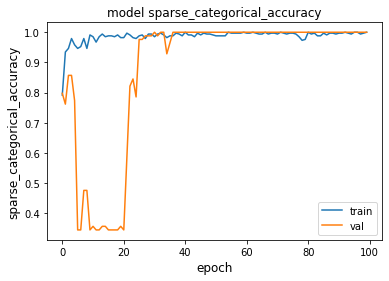

In [20]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


# Calculate feature importance

We use [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/index.html) to measure which feature has a larger effect on the model.

Ref https://medium.datadriveninvestor.com/time-step-wise-feature-importance-in-deep-learning-using-shap-e1c46a655455

In [21]:
shap.explainers._deep.deep_tf.op_handlers[
    "AddV2"
] = (
    shap.explainers._deep.deep_tf.passthrough
)  # see https://github.com/slundberg/shap/issues/1110#issuecomment-720337500

e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), X_train)

shap_val = e.shap_values(X_test)
np.array(shap_val).shape  # (num_class, X.shape)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


(2, 180, 148, 2)

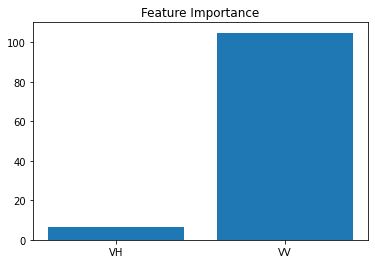

In [22]:
# As this is a binary classification problem, we only need to care about one class.
shap_val_ = np.array(shap_val[0])
shap_abs = np.absolute(shap_val_)

# We sum up the SHAP values along sample axis, and then along timestamps axis
# to get num_feature values as metrics of feature importance
feature_importance = np.sum(np.sum(shap_abs, axis=0), axis=0)
feature_name = ["VH", "VV"]
plt.figure()
plt.title("Feature Importance")
plt.bar(feature_name, feature_importance)
plt.show()
plt.close()


We can see that VV band values have a much larger impact on the model than VH band values. We can also validate this feature importance result by comparing the test accuracy of the model trained only by one of these features -- the test accuracy of the model trained only by VV feature is much higher than that trained only by VH feature. You are free to aggregate different features to change the model input in \#15 code trunk, and see the result by yourself.